# Time Series Segmentation with aeon
In this notebook, we explore some of the time series segmentation algorithms and benchmarks from the ECML/PKDD tutorial "An Introduction to Machine Learning from Time Series" with the aeon toolkit.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from tsdownsample import MinMaxLTTBDownsampler
from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

import aeon as ae
ae.AEON_DEPRECATION_WARNING = False

def plot_series_with_change_points(
    y, 
    change_points, 
    title=None, 
    ground_truth=None,
    font_size=16, 
    sample_to_points=1000):
    """Plot the time series with the known change points.

    Parameters
    ----------
    y: array-like, shape = [n]
        the univariate time series of length n to be annotated
    change_points: array-like, dtype=int
        the known change points
        these are highlighted in the time series as vertical lines
    title: str, default=None
        the name of the time series (dataset) to be annotated
    font_size: int, default=16
        for plotting

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : plt.Axis

    """
    # Checks availability of plotting libraries
    true_cps = np.sort(change_points)
    segments = [0] + list(true_cps) + [y.shape[0] - 1]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.25))
    colors = sns.color_palette("tab10")

    if sample_to_points < len(y):
        index = MinMaxLTTBDownsampler().downsample(y, n_out=sample_to_points)
        y_sampled = y[index]
        factor = max(1, len(y) / len(y_sampled))
    else:
        y_sampled = y
        index = np.arange(len(y), dtype=np.int32)
        factor = 1

    if ground_truth is not None:
        ground_truth = [0] + list(ground_truth) + [y.shape[0] - 1]        
        segments_to_plot = ground_truth
        legend_title="Predicted CPs"
        alpha=0.5
    else: 
        legend_title="Ground Truth"
        segments_to_plot = segments
        alpha=1.0
        
    for idx in np.arange(0, len(segments_to_plot) - 1):        
        start = np.int32(segments_to_plot[idx] // factor)
        end = np.int32((segments_to_plot[idx+1] +1)// factor)
        ax.plot(
            index[range(start, end)],
            y_sampled[start : end],
            color=colors[idx % len(colors)],
            alpha=alpha
        )
    
    lim1 = plt.ylim()[0]
    lim2 = plt.ylim()[1]

    for i, idx in enumerate(true_cps):
        ax.vlines(index[np.int32(idx // factor)], lim1, lim2, linestyles="--", linewidth=3,
                  label=f"ChP {i}", color=colors[i % len(colors)])

    plt.legend(loc="best", title=legend_title)

    # Set the figure's title
    if title is not None:
        fig.suptitle(title, fontsize=font_size)

    return fig, ax

Let's start with importing the necessary resources. You can find eight segmentation algorithms in the module aeon.segmentation and two segmentation benchmarks in aeon.datasets.

In [2]:
from aeon.segmentation import ClaSPSegmenter, FLUSSSegmenter, BinSegSegmenter, find_dominant_window_sizes
from aeon.datasets import load_time_series_segmentation_benchmark, load_human_activity_segmentation_datasets
from aeon.visualisation import plot_series_with_profiles

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# The Time Series Segmentation Task
The task of time series segmentation (TSS) is to find the segmentation of a time series (TS) that corresponds to the sequence of captured states in the data-generating process. Algorithms must find all offsets, called change points (CPs), that divide TS into segments. This is an unsupervised machine learning (ML) problem.

In [3]:
X, y = load_time_series_segmentation_benchmark()

idx = 12
ts, cps = X[idx], y[idx]

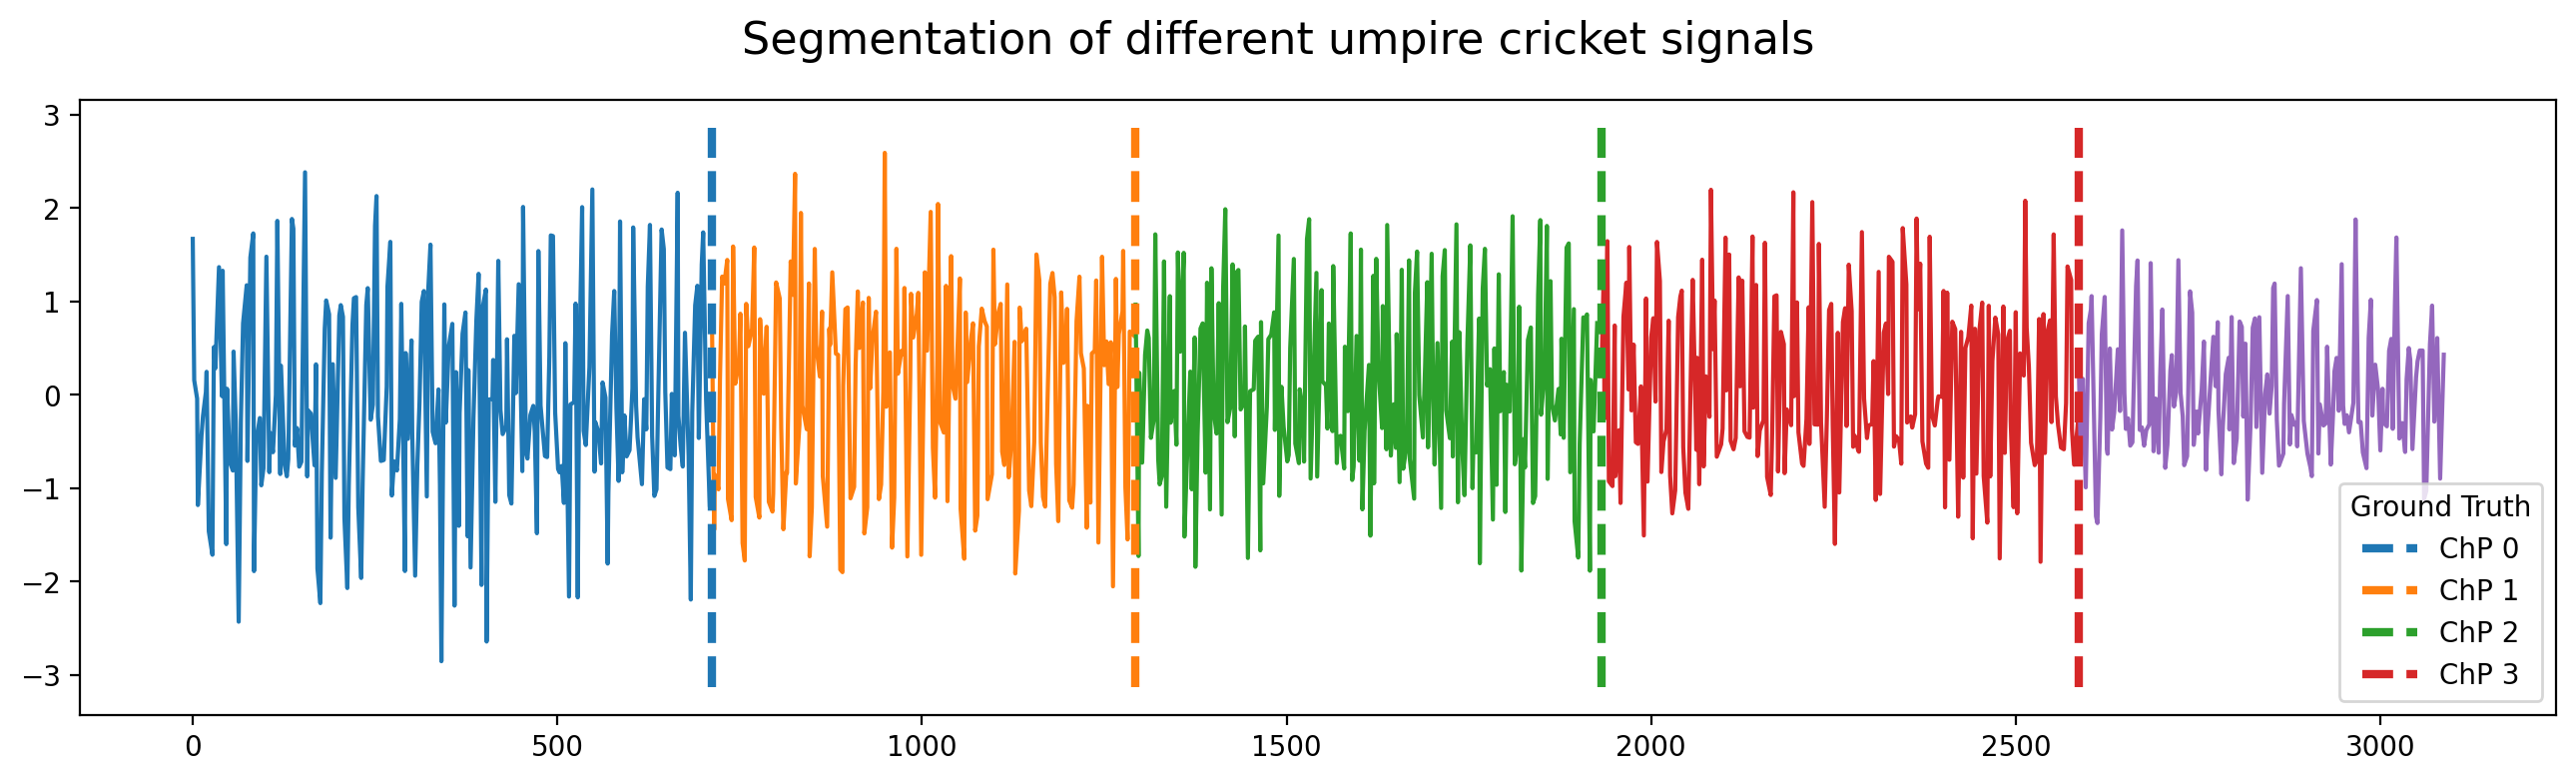

In [4]:
_ = plot_series_with_change_points(pd.Series(ts), cps, title="Segmentation of different umpire cricket signals")

The above example shows a Cricket data set that contains motions of different umpire signals captured as wrist acceleration. Each segment (coloured subsequence) contains multiple instances of one particular signal and the vertical lines denote CPs at which the signal changes. 

# Binary Segmentation
The Binary Segmentation algorithm recursively splits a TS into two subsequences to minimize the cost of both segments. Different cost functions are available that quantify the heterogeneity of a segment, e.g. using mean deviation or autoregression. 

We choose the BinSegSegmenter in aeon and set the number of exepcted CPs as well as the cost function to predict the location of CPs.

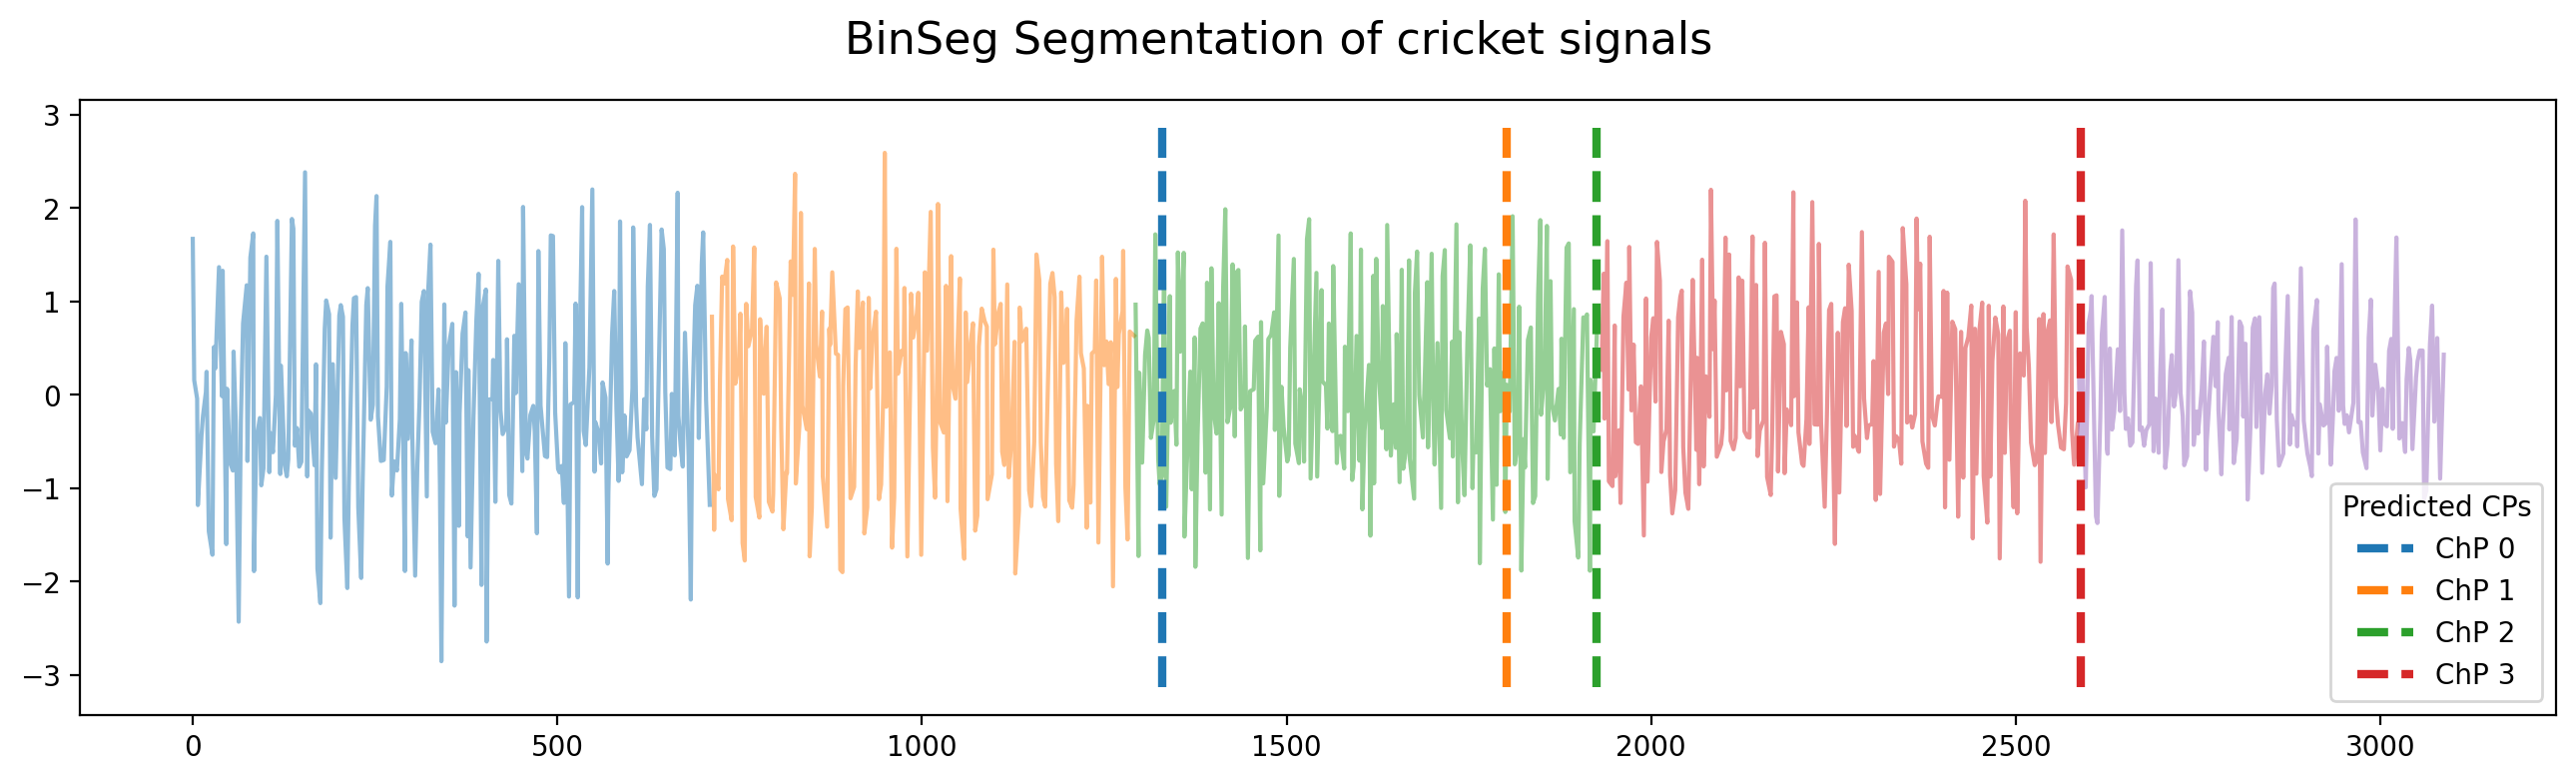

In [5]:
binseg = BinSegSegmenter(n_cps=len(cps), model="ar")
found_cps = binseg.fit_predict(ts)
_ = plot_series_with_change_points(pd.Series(ts), found_cps, ground_truth=cps, title="BinSeg Segmentation of cricket signals")

In this example, Binary Segmentation correctly identifies 3 of the 4 CPs.

# FLUSS
The FLUSS algorithm uses the matrix profile (1-nearest neighbour subsequence relationships) to find groups of similar, co-located subsequences in TS. It creates an arc curve from which such groups are retrieved.

Before we run FLUSS, we need to determine the window size of the TS. We do this by extracting its most dominant frequency. Then we call the FLUSSSegmenter using the window size and number of expected segments.

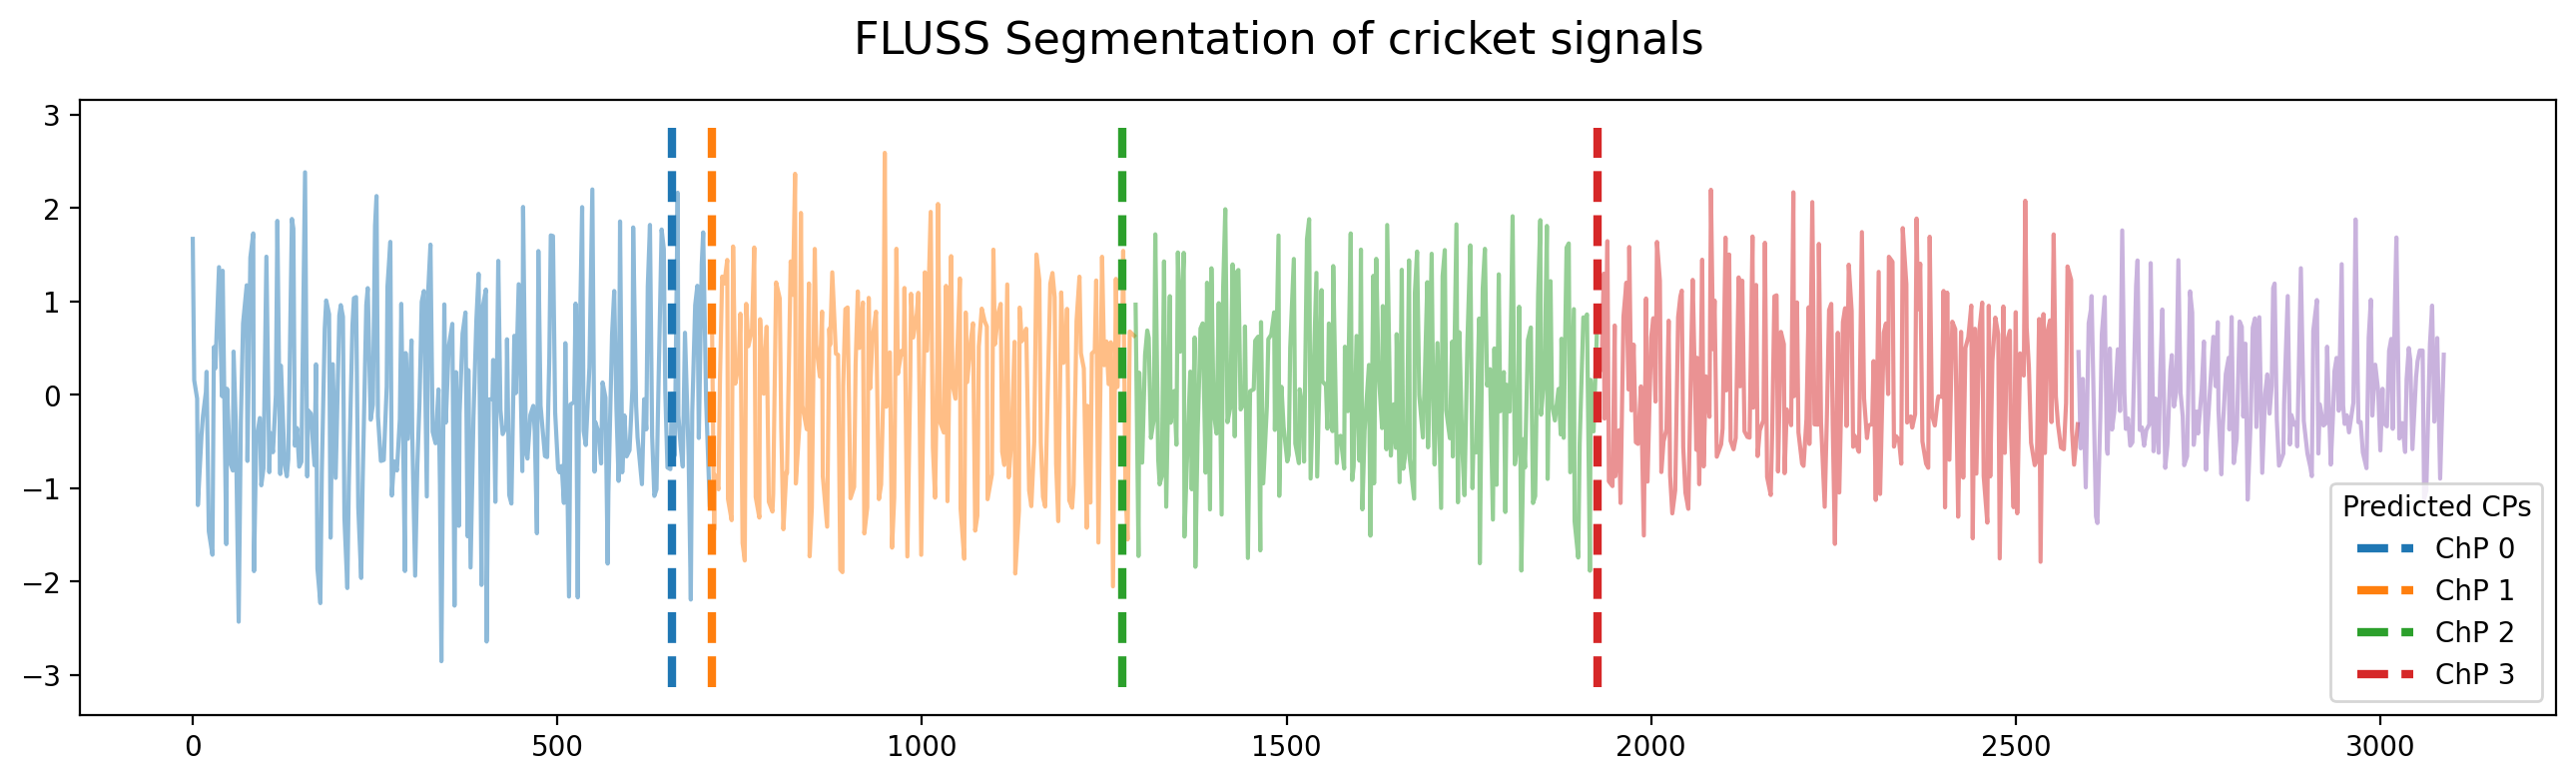

In [6]:
window_size = find_dominant_window_sizes(ts)
fluss = FLUSSSegmenter(period_length=window_size, n_regimes=len(cps)+1)
found_cps = fluss.fit_predict(ts)
_ = plot_series_with_change_points(pd.Series(ts), found_cps, ground_truth=cps, title="FLUSS Segmentation of cricket signals")

Similarly to Binary Segmentation, FLUSS correctly retrieves 3 out of 4 CPs.

# ClaSP
The ClaSP algorithm frames segmentation as a collection of self-supervised binary subsequence classification problems, where each subsequence either belongs to the left or right segment. It recursively splits TS into two segments to maximise their self-supervised cross-validation performance.

Like FLUSS, ClaSP needs a window size. We use it in combiantion with the number of CPs to call the ClaSPSegmenter.

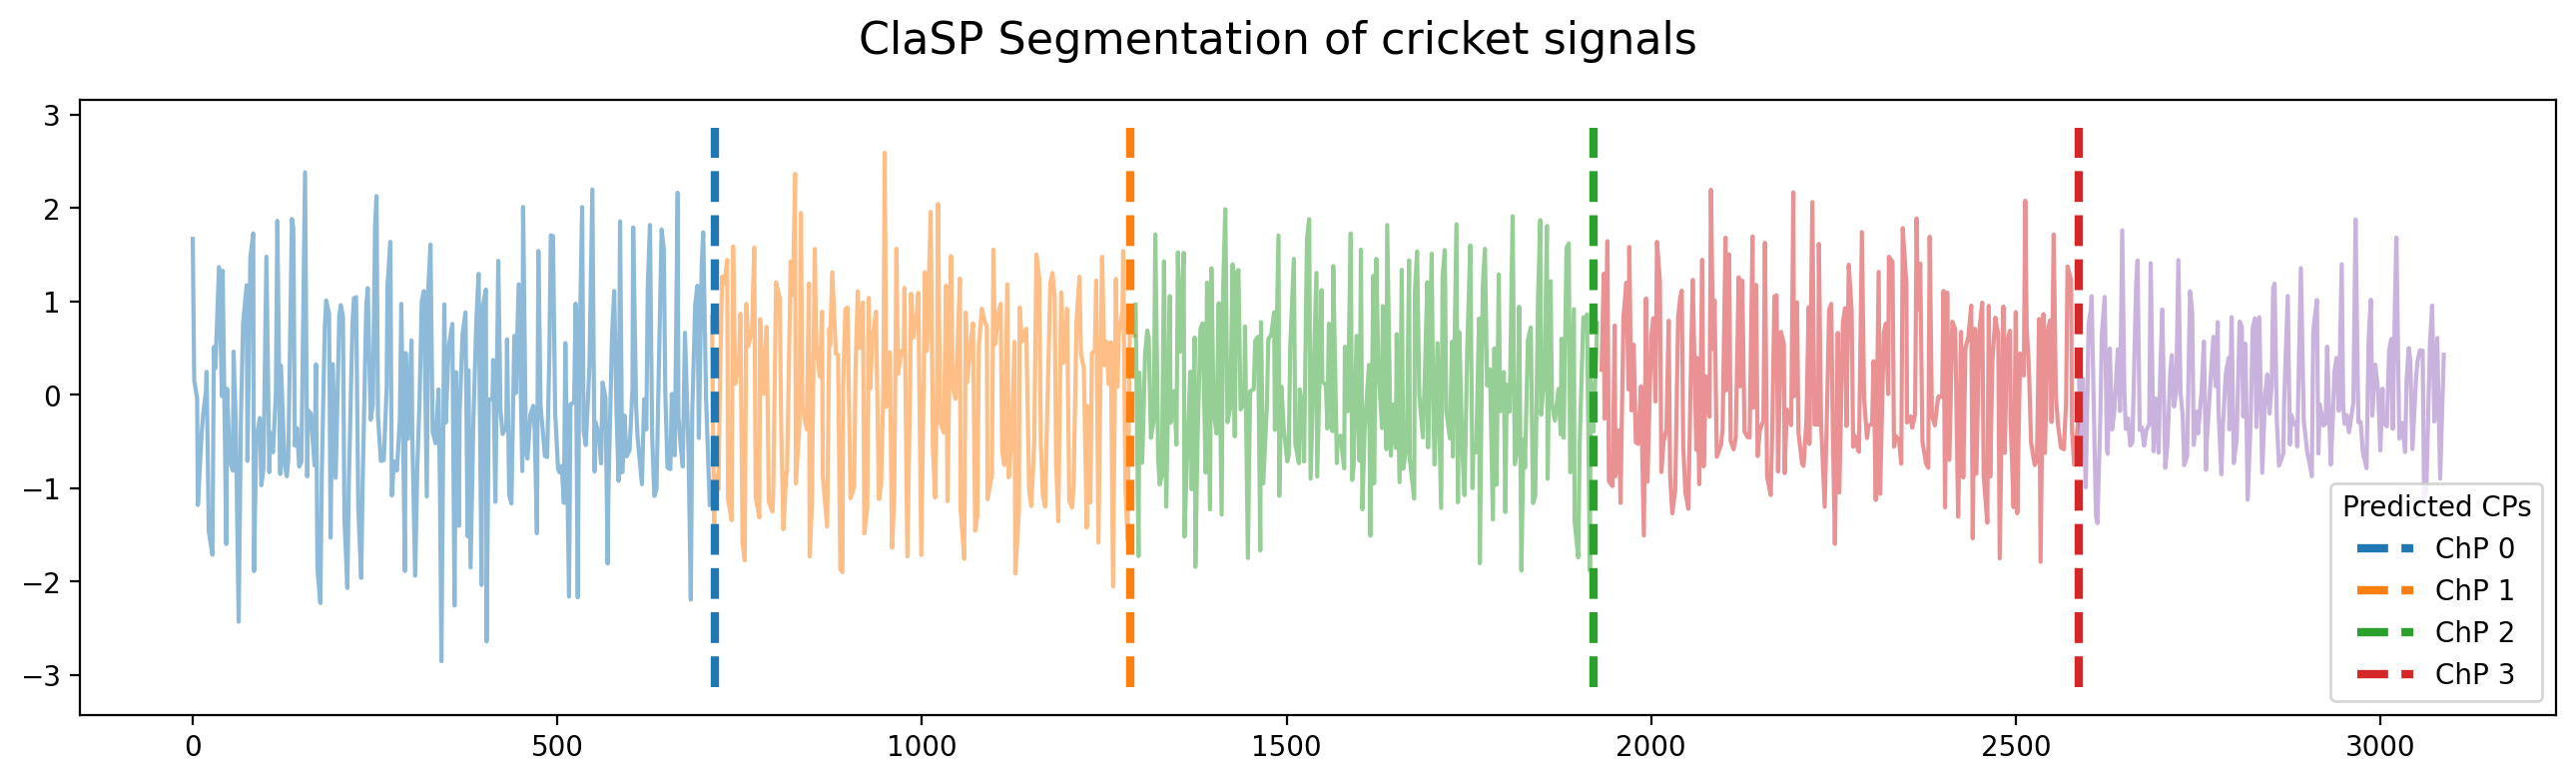

In [7]:
window_size = find_dominant_window_sizes(ts)
clasp = ClaSPSegmenter(period_length=window_size, n_cps=len(cps))
found_cps = clasp.fit_predict(ts)
_ = plot_series_with_change_points(pd.Series(ts), found_cps, ground_truth=cps, title="ClaSP Segmentation of cricket signals")

ClaSP correctly identifies all CPs for this example.

# Time Series Segmentation Benchmark
The time series segmentation benchmark (TSSB) contains 75 annotated TS with 1-9 segments. Each TS is constructed from one of the UEA & UCR time series classification problems. TS are grouped by label and concatenated to create segments with distinctive temporal patterns and statistical properties. The offsets at which segments are concatenated are annotated as CPs. Addtionally, resampling is applied to control the data set resolution.

We load the benchmark and get two lists containing TS and corresponding CPs.

In [8]:
X, y = load_time_series_segmentation_benchmark()

In [9]:
print(f"No. of TS: {len(X)}")
ts_lens = [len(ts) for ts in X]
print(f"TS size: {np.min(ts_lens)} / {np.median(ts_lens)} / {np.max(ts_lens)}")
print(f"No. of Channels: 1")
cp_lens = [len(cps) for cps in y]
print(f"No. of Segments: {np.min(cp_lens)} / {np.median(cp_lens)} / {np.max(cp_lens)}")

No. of TS: 75
TS size: 240 / 3456.0 / 20700
No. of Channels: 1
No. of Segments: 0 / 2.0 / 8


## Example: Adiac
The Adiac TS contains segments of different image outlines. Each segment constitutes multiple instances of the same shape. The original data set is described here: https://timeseriesclassification.com/description.php?Dataset=Adiac

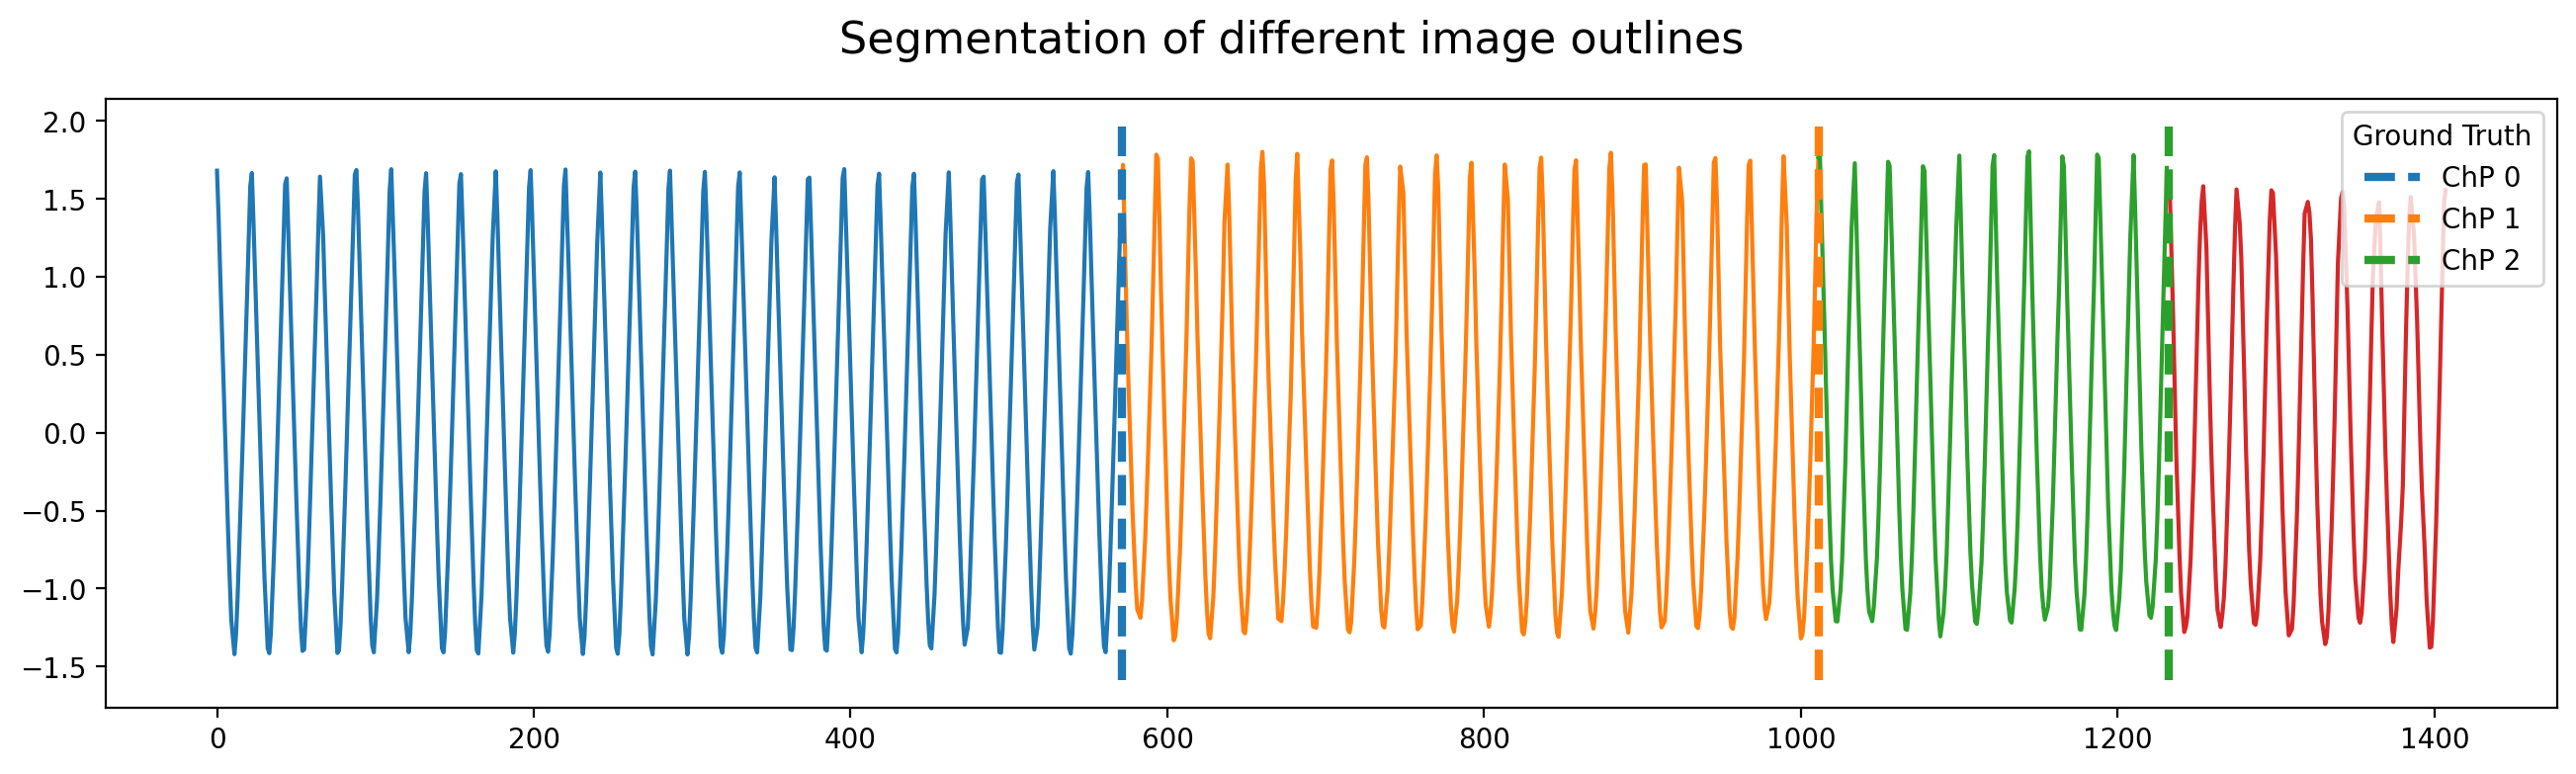

In [10]:
_ = plot_series_with_change_points(pd.Series(X[0]), y[0], title="Segmentation of different image outlines")

# Human Activity Segmentation Challenge Benchmark
The human activity segmentation challenge benchmark consists of 250 multivariate TS (MTS), from a shared task at ECML/PKDD and the AALTD 2023 workshop. The data originates from 40 twelve-dimensional smartphone recordings, capturing 15 students performing 6 distinct motion sequences in both indoor and outdoor settings. Each data set includes values from 9 out of 12 sensors. The MTS are annotated with activity transition offsets as ground truth.

We load the benchmark and get two lists containing MTS and corresponding CPs.

In [11]:
X, y = load_human_activity_segmentation_datasets()

In [12]:
print(f"No. of TS: {len(X)}")
ts_lens = [ts.shape[0] for ts in X]
print(f"TS size: {np.min(ts_lens)} / {np.median(ts_lens)} / {np.max(ts_lens)}")
print(f"No. of Channels: 9")
cp_lens = [len(cps) for cps in y]
print(f"No. of Segments: {np.min(cp_lens)} / {np.median(cp_lens)} / {np.max(cp_lens)}")

No. of TS: 250
TS size: 340 / 4985.5 / 41465
No. of Channels: 9
No. of Segments: 0 / 3.0 / 14


## Example: Indoor sport routine
The TS shows the X-axis acceleration, gyroscope and magnetometer readings from a 25-year-old male performing a sequence of sport exercises. Each segment captures repetitions of one exercise, e.g. multiple instances of jumping jacks.

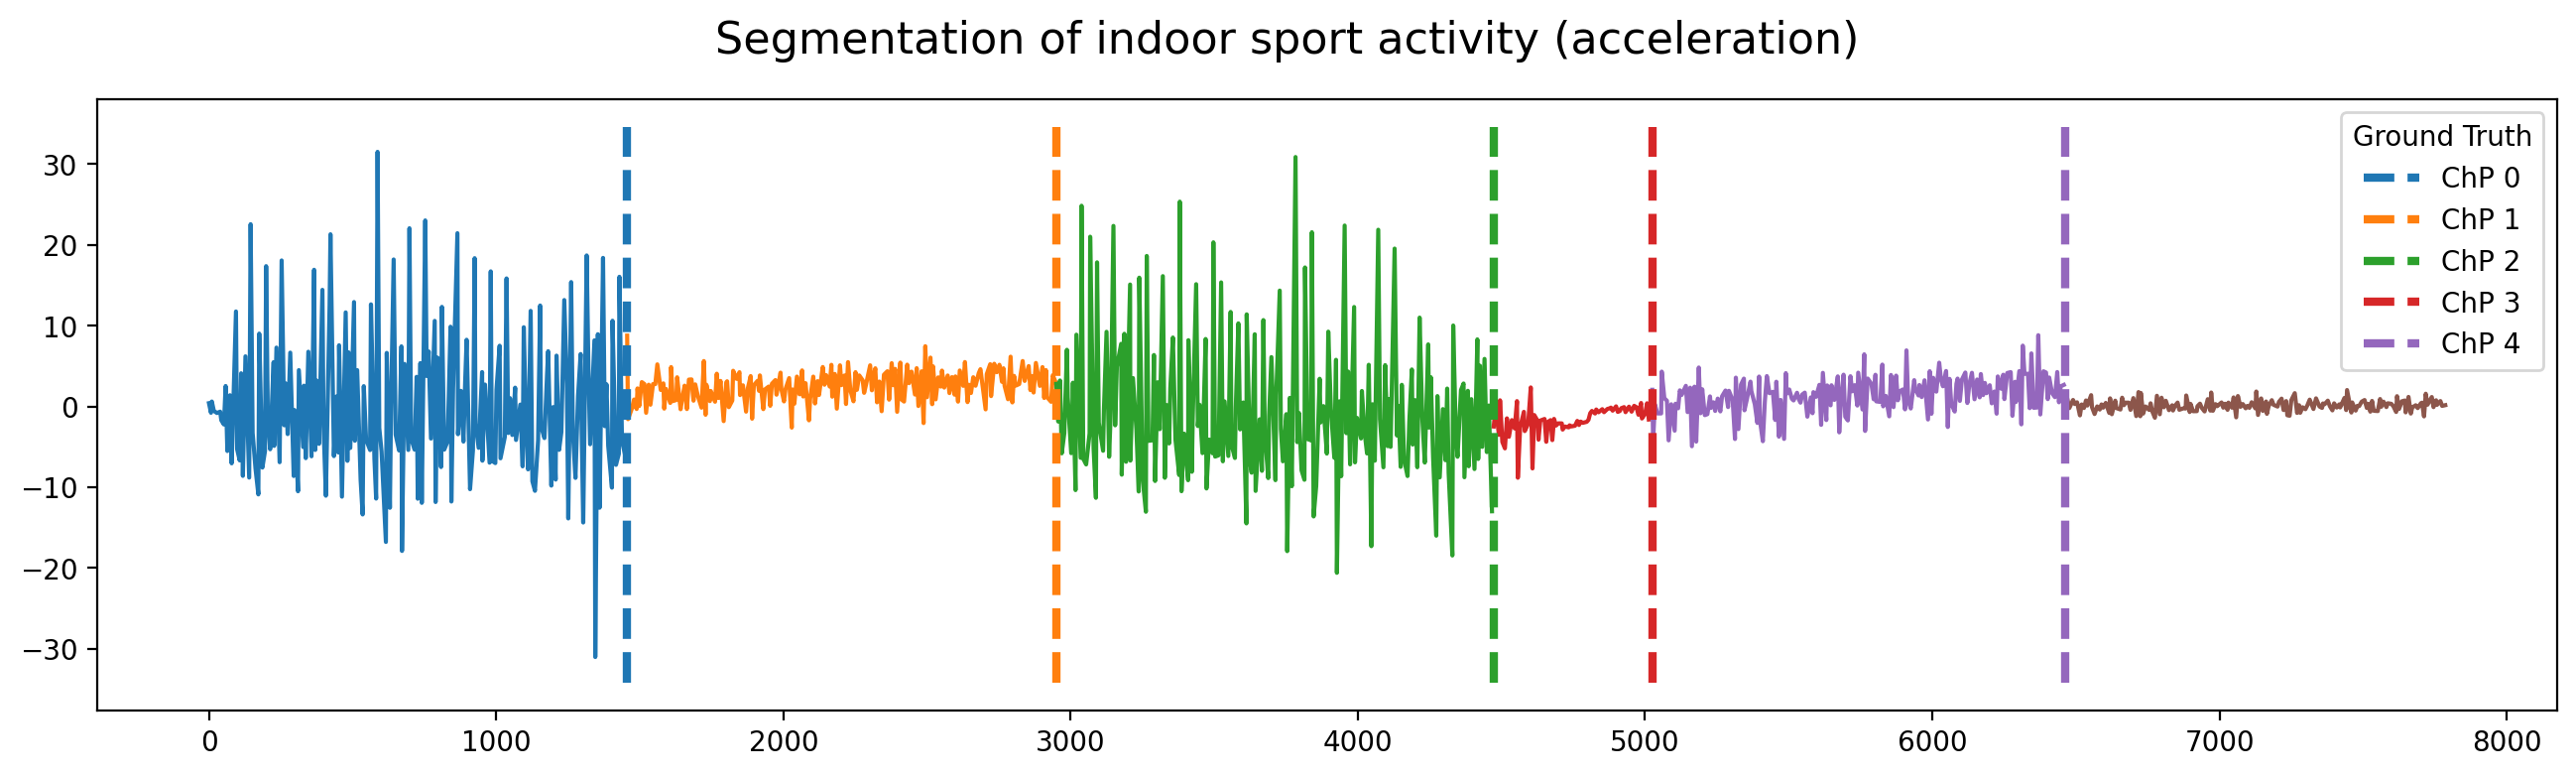

In [13]:
_ = plot_series_with_change_points(pd.Series(X[0][:,0]), y[0], 
                                   title="Segmentation of indoor sport activity (acceleration)",
                                   sample_to_points=1000)

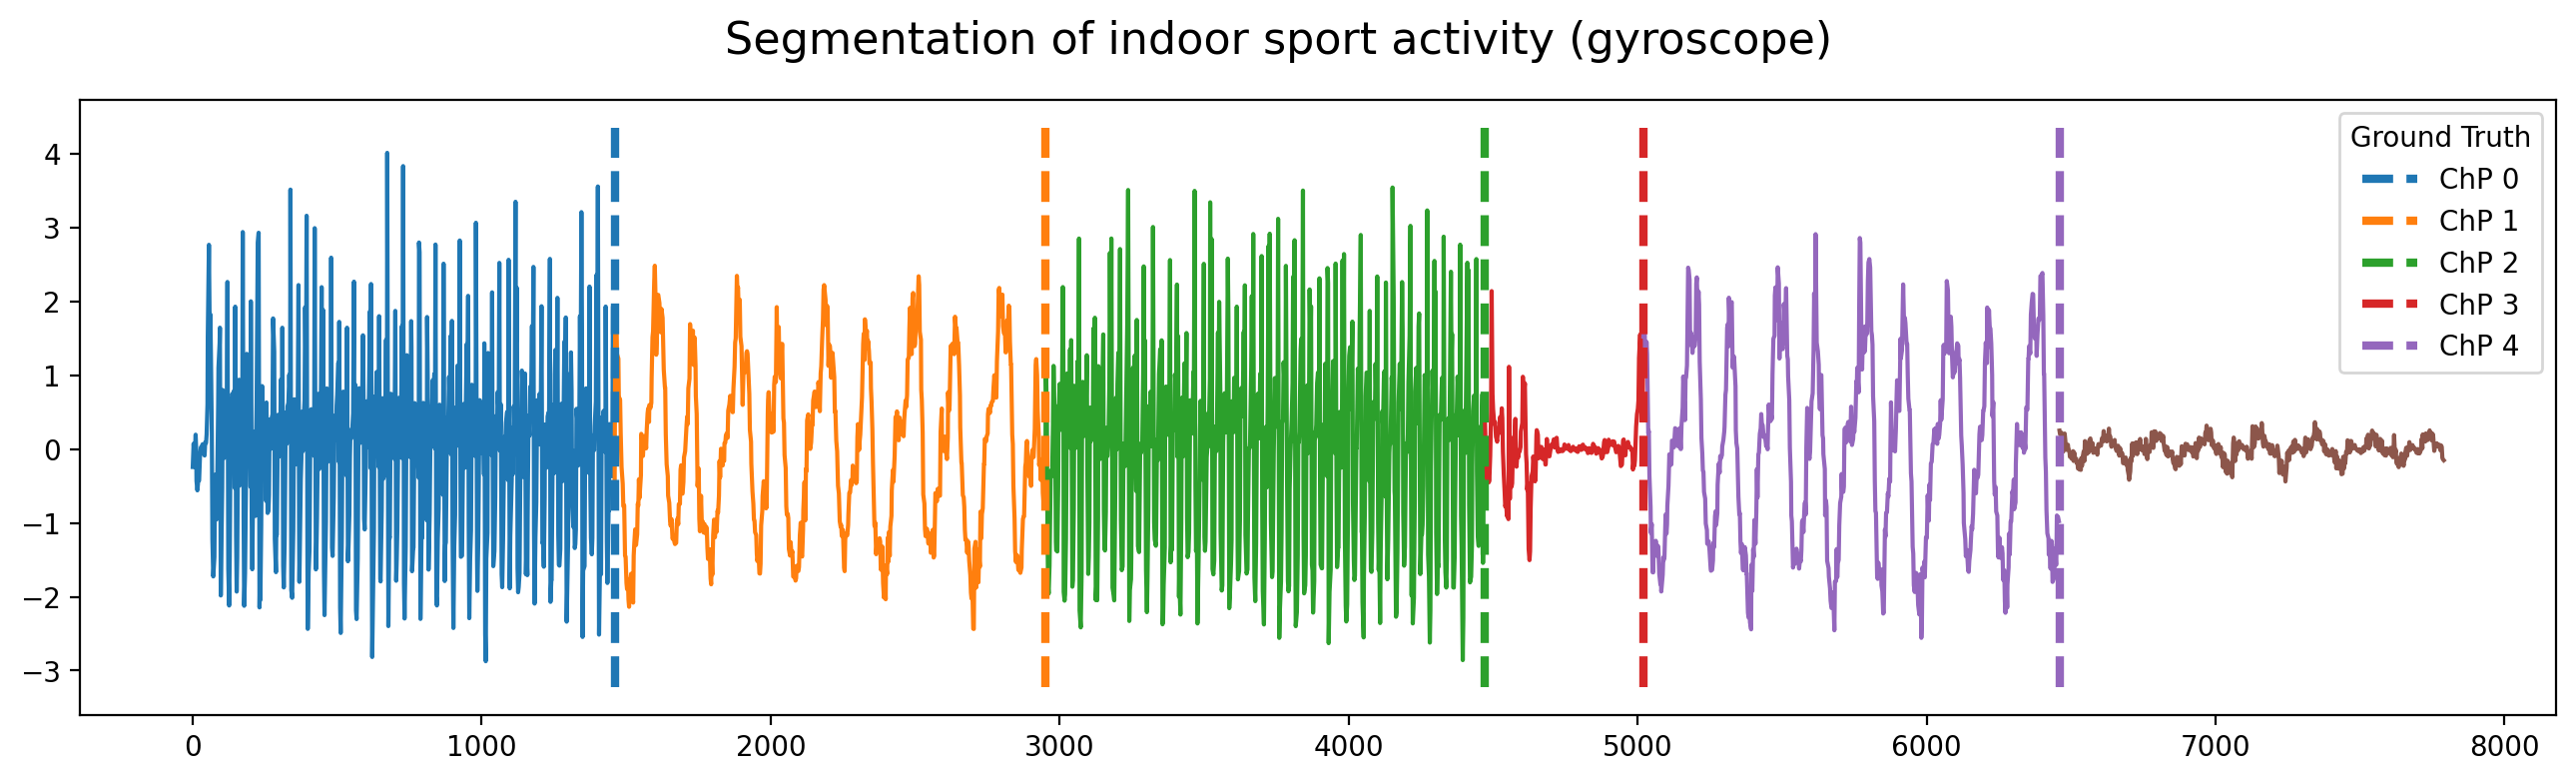

In [14]:
_ = plot_series_with_change_points(pd.Series(X[0][:,3]), y[0], 
                                   title="Segmentation of indoor sport activity (gyroscope)",
                                   sample_to_points=1000)

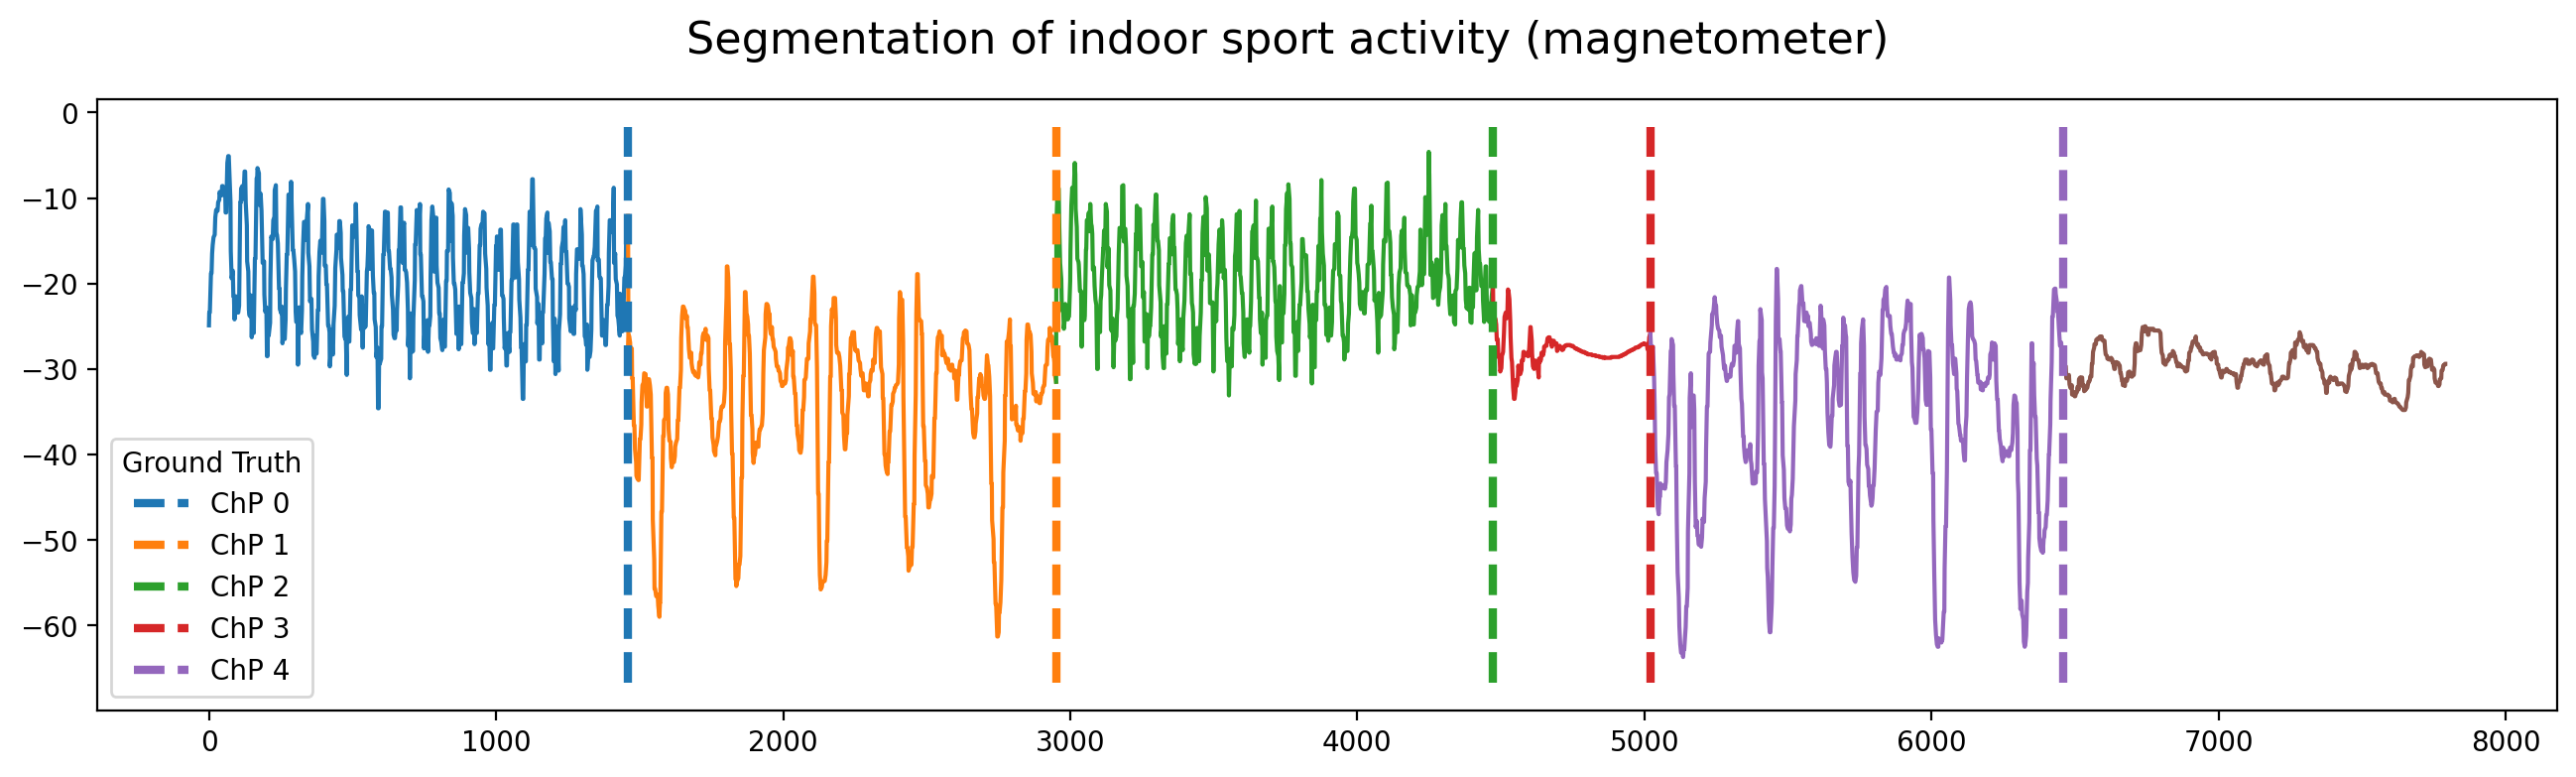

In [15]:
_ = plot_series_with_change_points(pd.Series(X[0][:,6]), y[0], 
                                   title="Segmentation of indoor sport activity (magnetometer)",
                                   sample_to_points=1000)

# Use Case: Crop
The Crop data set from the TSSB contains a satellite image TS capturing different crops as segments. The original data set is available here: https://timeseriesclassification.com/description.php?Dataset=Crop

We explore the arc curve, produced by FLUSS, and the classification score profile, from ClaSP, for this example. Both annotate the TS with scores. The arc curve contains CPs as local minima, while the classification score profile illustrates CPs as local maxima.

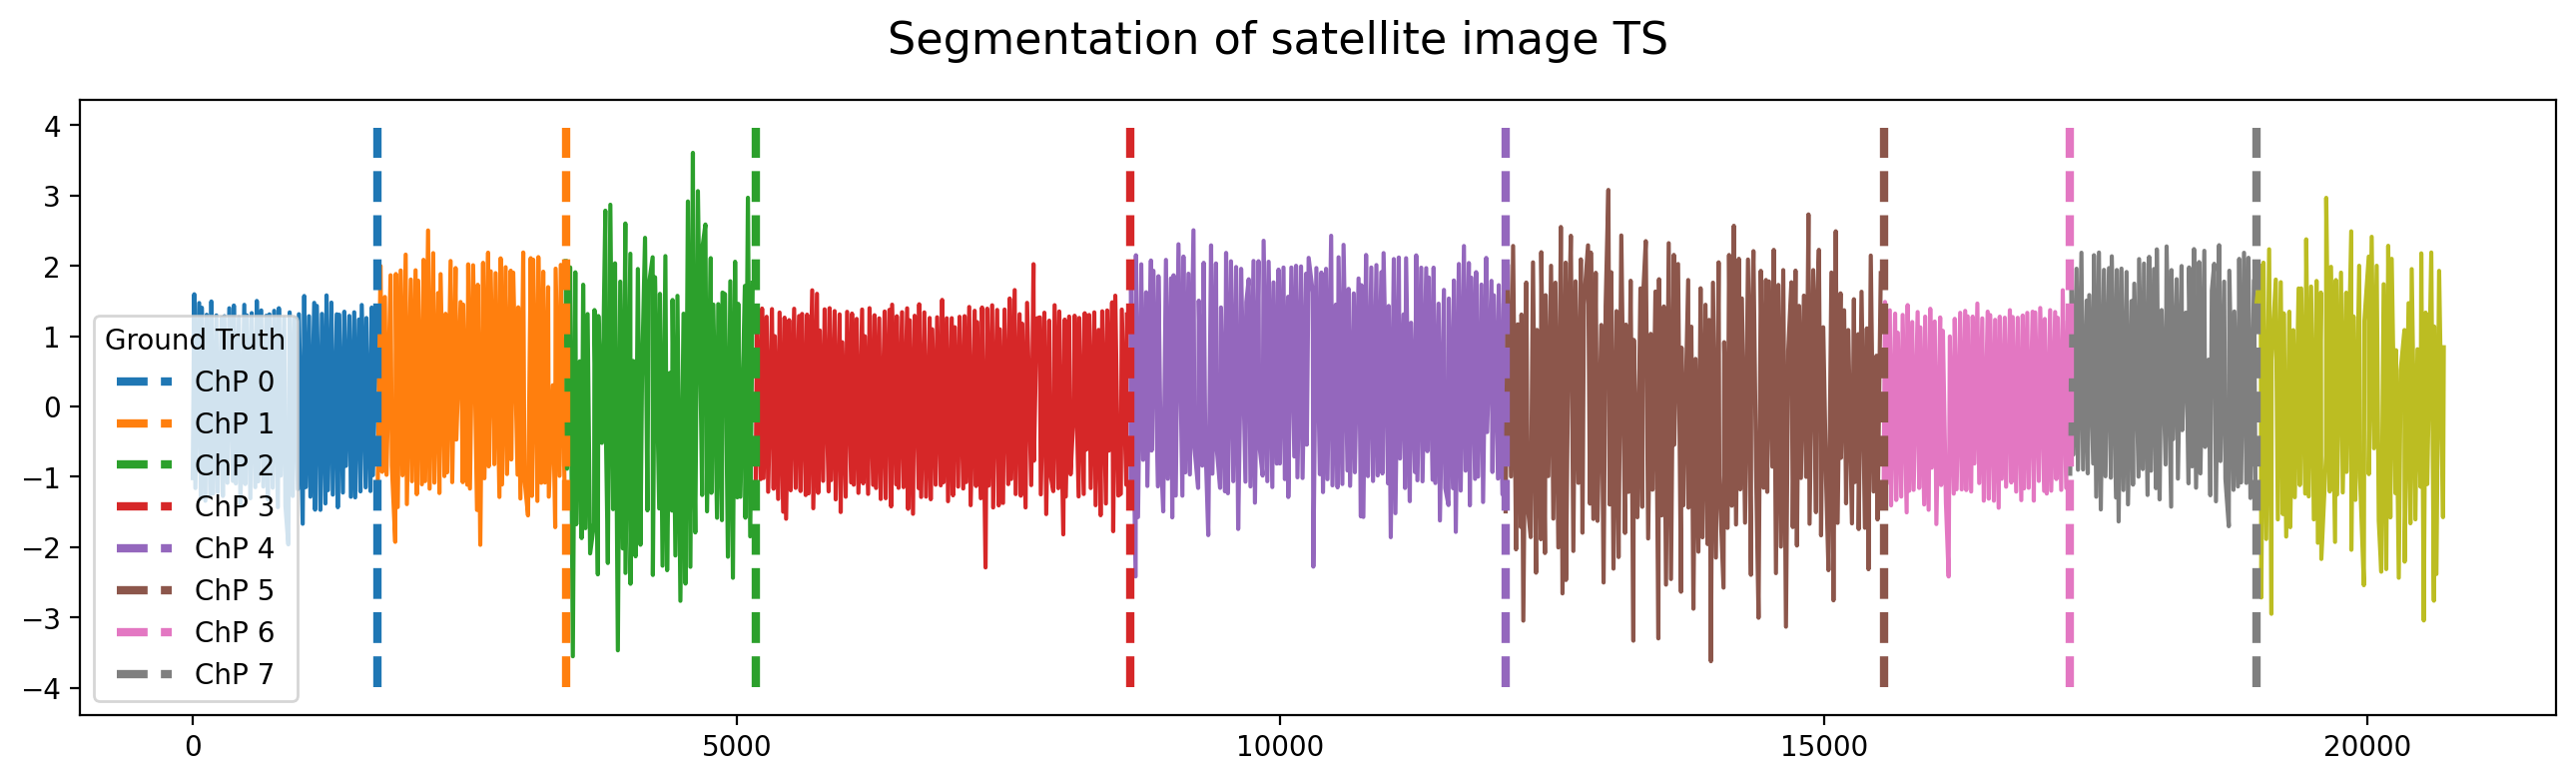

In [16]:
X, y = load_time_series_segmentation_benchmark()
ts, cps = X[15], y[15]
_ = plot_series_with_change_points(pd.Series(ts), cps, title="Segmentation of satellite image TS")

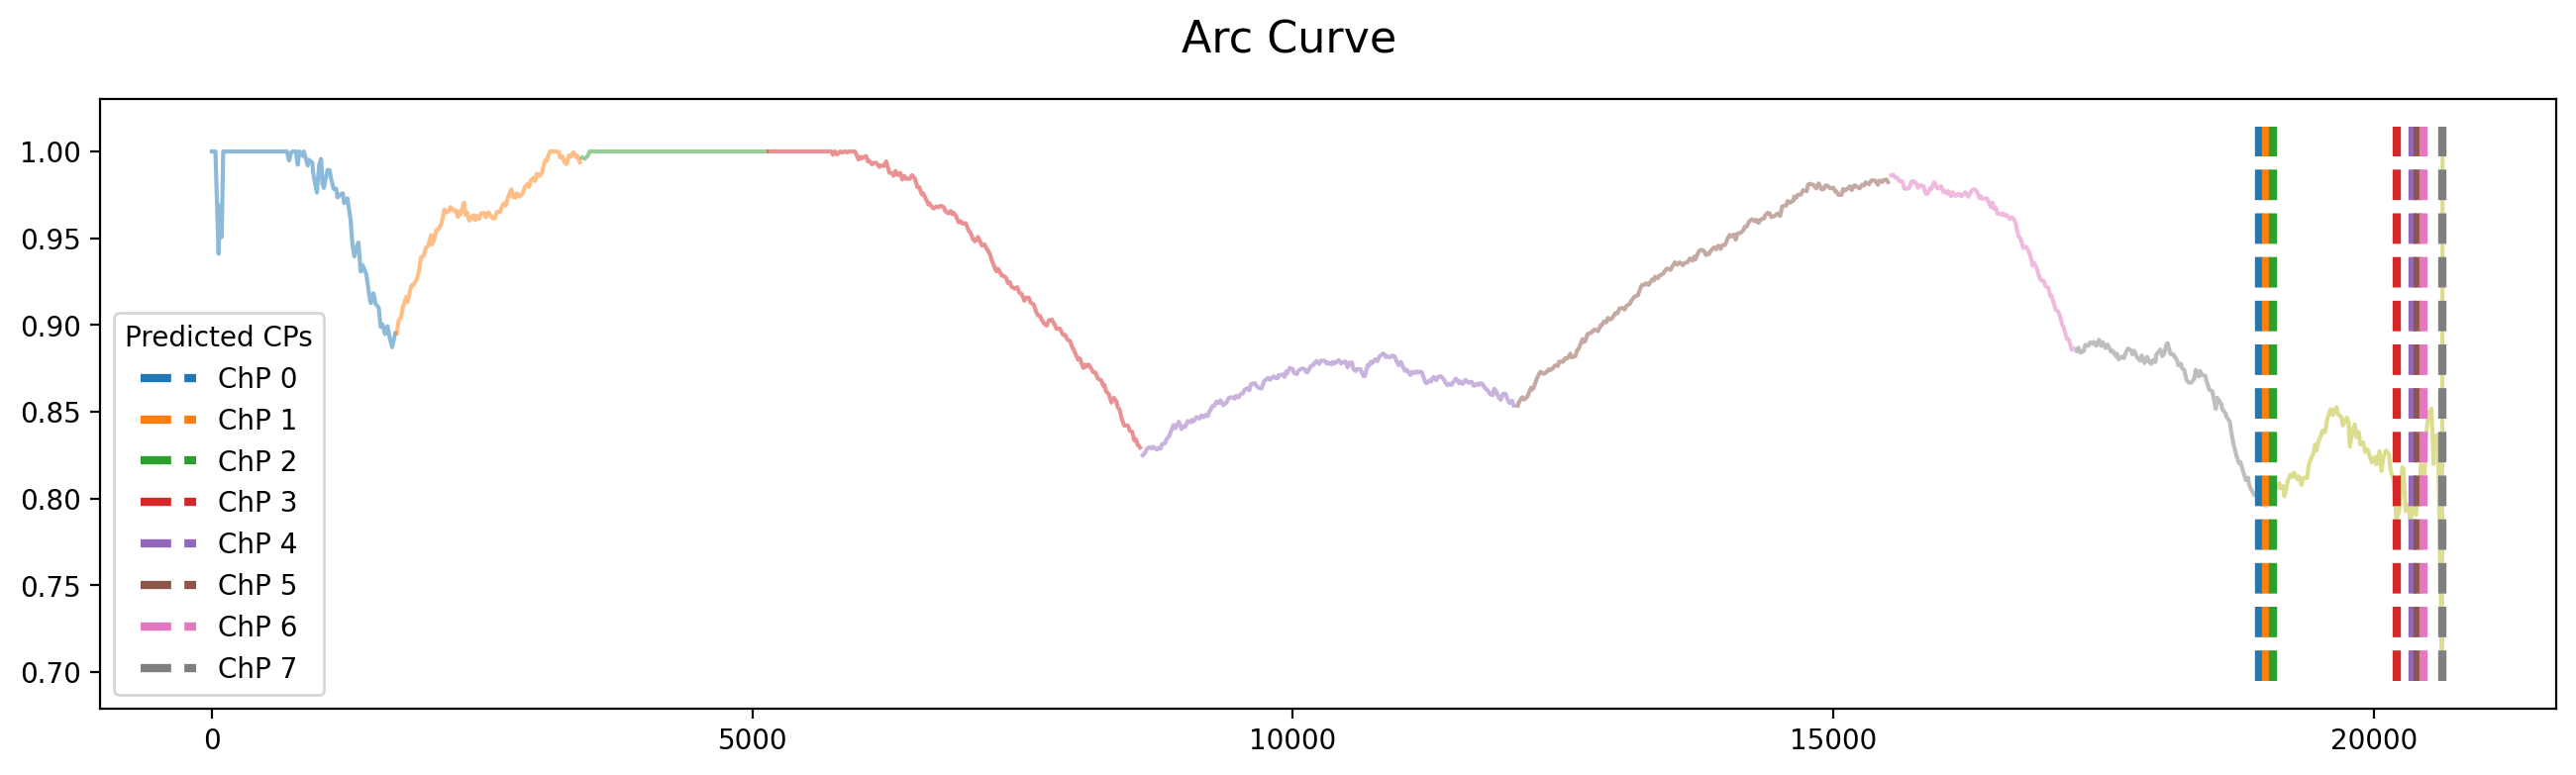

In [17]:
window_size = find_dominant_window_sizes(ts)
fluss = FLUSSSegmenter(period_length=window_size, n_regimes=len(cps)+1)
fluss_cps = fluss.fit_predict(ts)
_ = plot_series_with_change_points(pd.Series(fluss.profile), fluss_cps, ground_truth=cps, title="Arc Curve")

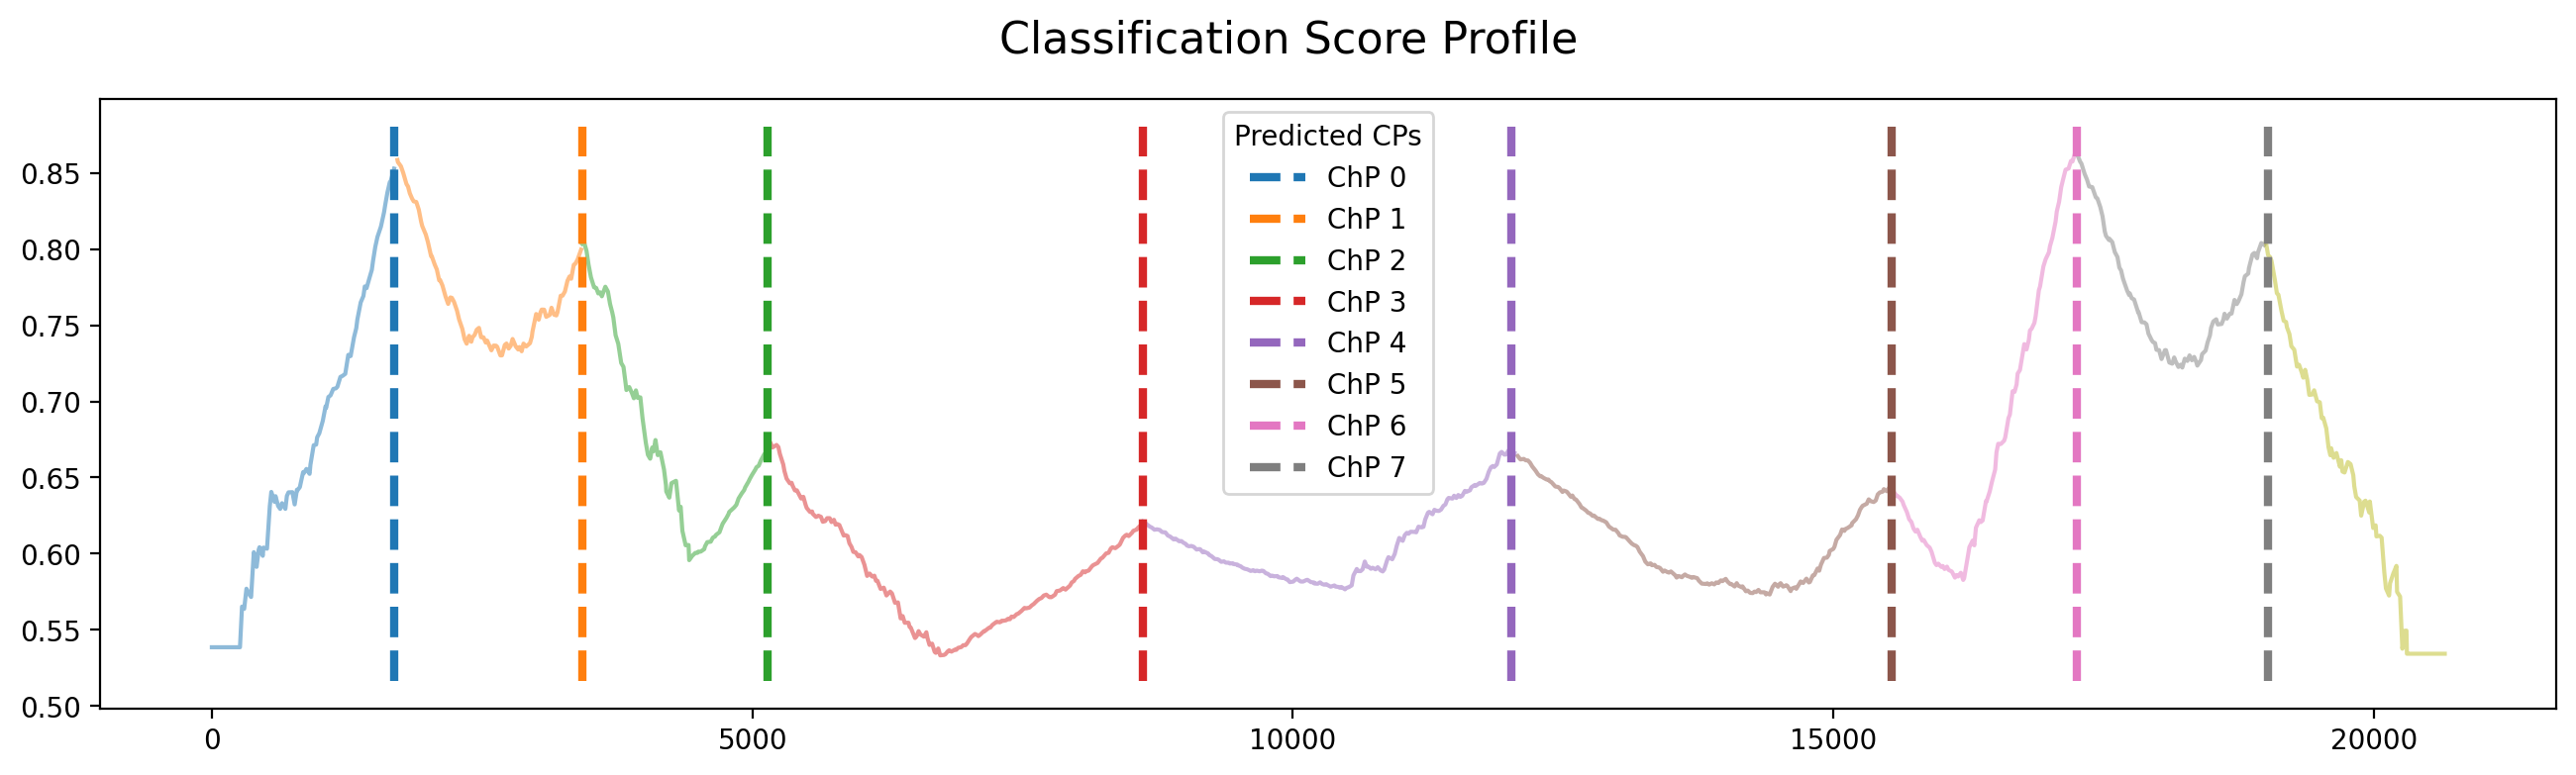

In [18]:
clasp = ClaSPSegmenter(period_length=window_size, n_cps=len(cps))
clasp_cps = clasp.fit_predict(ts)

# aggregate profiles into one
min_profile_len = np.min([profile.shape[0] for profile in clasp.profiles])
clasp_profile = np.max(np.array([profile[:min_profile_len] for profile in clasp.profiles]), axis=0)

_ = plot_series_with_change_points(pd.Series(clasp_profile), clasp_cps, ground_truth=cps, title="Classification Score Profile")

FLUSS captures many CPs in its arc curve, but fails to correctly retrieve them for this example. ClaSP captures all CPs in its profile and correctly extracts them. 